# DenseNet
`DenseNet` 使用了 `ResNet` 改良版的 `batch normalization` 、激活函数和卷积架构

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

In [17]:
def conv_block(input_channels,num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),nn.ReLU(),
        nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1))

## [稠密块]

一个稠密块由多个卷积快组成，每个卷积块使用相同数量的输出通道。在前向传播中，将每个卷积块的输入和输出在 `channel` 上连结

In [18]:
class DenseBlock(nn.Module):
    def __init__(self,num_convs,input_channels,num_channels):
        super(DenseBlock,self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(input_channels + i * num_channels,num_channels))
        self.net = nn.Sequential(*layer)
    def forward(self,X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X,Y),dim=1)
            
        return X

**例子**
`2` 个 `DenseBlock` ，输出通道为 `10` ，当输入通道数为 `3` 时，会得到通道数为 $10*2+3=23$ 的输出。

卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被叫做 *增长率*

In [19]:
blk = DenseBlock(2,3,10)
X = torch.rand(4,3,8,8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## [过渡层]
随着稠密块的增加，输出通道数也会增加，当输出通道数过多时，模型也会变得更复杂。

过渡层的作用就是控制模型复杂度，（1）它利用 $1\times 1$ 卷积核来控制输出通道数，（2）并使用步幅为 `2` 的平均汇聚层来减半高度和宽度，进一步降低模型复杂度

In [20]:
def transition_block(input_channels,num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),nn.ReLU(),
        nn.Conv2d(input_channels,num_channels,kernel_size=1),
        nn.AvgPool2d(kernel_size=2,stride=2))

再次使用上一个例子

In [21]:
blk = transition_block(23,10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

# DenseNet模型

`DenseNet` 与 `ResNet` 一样，先通过：
- $7\times 7$ 卷积层，步幅为 `2` ，填充为 `3`
- $3\times 3$ 最大汇聚层，步幅为 `2` ，填充为 `1`

In [22]:
b1 = nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

接下来，类似 `ResNet` 的 `4` 个模块（残差块构成），`DenseNet` 使用 `DenseBlock` 。
这里设置每个稠密块有 `4` 个卷积层，与 `ResNet-18` 保持一致。卷积层的输出通道数（增长率）设为 `32` ，所以每个卷积块会增加 $32*4$ 个通道

每个模块之间，`ResNet` 通过步幅为 `2` 减半分辨率，`DenseNet` 使用 `transition block` 来减半

In [25]:
num_channels,growth_rate = 64,32
num_convs_in_dense_blocks = [4,4,4,4] # 4个稠密块，每个稠密块中有4层卷积层
blks = []
for i,num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs,num_channels,growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密层之间加一个过渡层，防止输出通道书过多，最后一个不加
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels,num_channels//2))
        num_channels = num_channels // 2
    

In [26]:
net = nn.Sequential(
    b1,*blks,
    nn.BatchNorm2d(num_channels),nn.ReLU(),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(num_channels,10))

loss 0.140, train acc 0.949, test acc 0.830
207.3 examples/sec on cpu


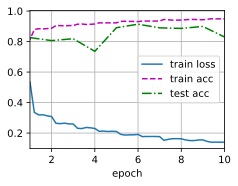

In [27]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())